# Modèle de segmentation
## Chris HOZE - Nov 2024

Inspiré depuis pour le modèle

https://www.kaggle.com/code/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset 

Et pour les métriques

https://www.kaggle.com/code/sajeelhashmi/image-segmentation#Get-Metrics

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
#from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")

dim=256
size_max_cat = 3000 # None if we want the whole dataset
batch_size = 8

In [2]:
#visualise image and mask 
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()


In [3]:
import random


def getData(X_shape, N = None):
    im_array = []
    mask_array = []

    for cat in ["Normal", "Lung_Opacity", "Viral_Pneumonia", "COVID"]:       
        image_path = os.path.join(data_folder_path,cat,"images")
        mask_path = os.path.join(data_folder_path,cat,"masks")
        files = os.listdir(image_path)
        random.Random(1337).shuffle(files)
        
        if (N is None):
            N = len(files)
        else:
            N = min(N, len(files))
        for i in files[:N]: 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]  
            im_array.append(im)
            mask_array.append(mask)
    
    images = np.array(im_array).reshape(len(im_array),dim,dim,1)
    masks = np.array(mask_array).reshape(len(mask_array),dim,dim,1)
    return images, masks

visualize dataset


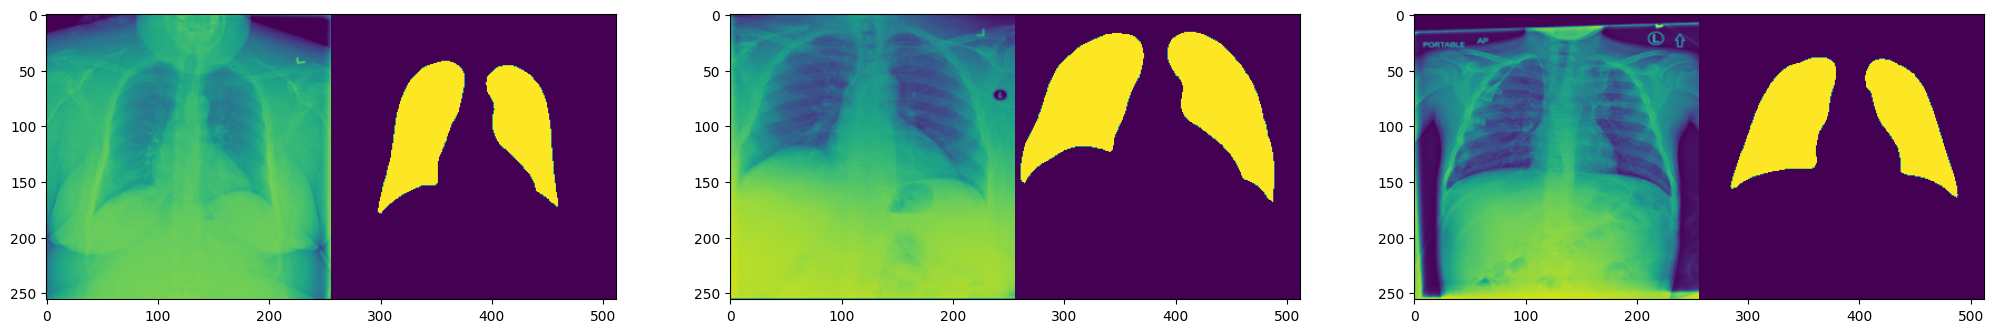

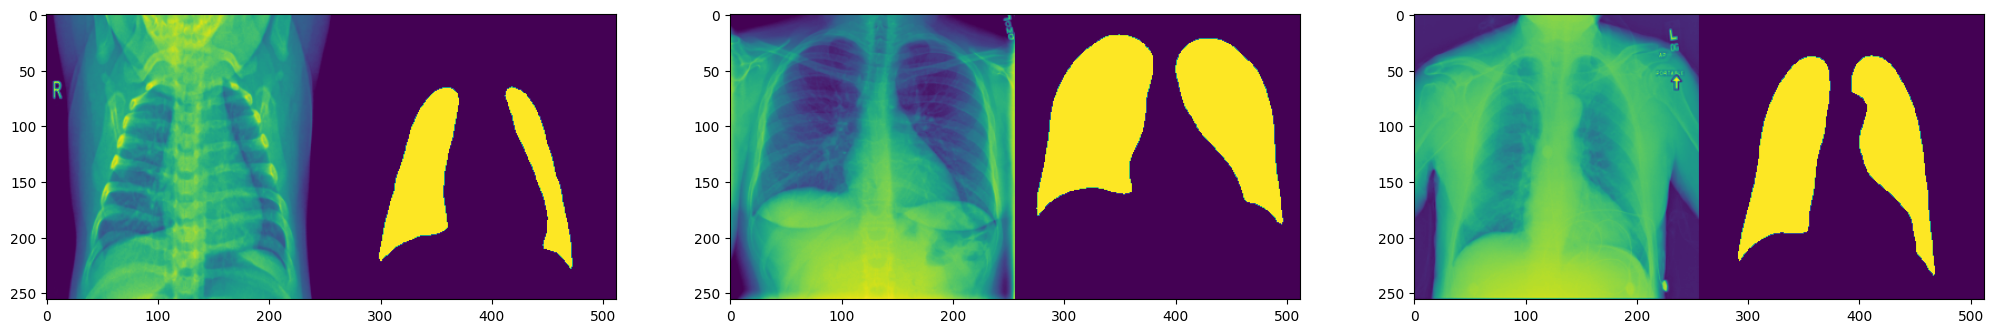

dataset size : images (8690, 256, 256, 1) masks (8690, 256, 256, 1)
Shape de image_scaled:  (8690, 256, 256, 1) type de image_scaled:  uint8


In [58]:
# Importing data
dim = 256
images, masks = getData(dim,N=size_max_cat)

print("visualize dataset")
plotMask(images, masks)


print("dataset size : images", images.shape, "masks", masks.shape)


print("Shape de image_scaled: ", images.shape, "type de image_scaled: ", images.dtype)



In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(dim,dim,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [26]:

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_segmentation.best.keras".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min') #save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min",
                      min_delta=0.0001,
                      patience=5)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [37]:

model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss="Dice",
                  metrics=['BinaryIoU','binary_accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
from sklearn.model_selection import train_test_split

train_vol, valid_vol, train_seg, valid_seg = train_test_split((images-127)/127, 
                                                             (masks>127).astype(np.float32),
                                                             test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

datagen = ImageDataGenerator() 

# Augmenter respectivement les jeu de données d'entrainement
train_dataset = datagen.flow(train_vol, train_seg, batch_size = batch_size)

test_dataset = datagen.flow(test_vol, test_seg, batch_size = batch_size)

val_dataset = datagen.flow(valid_vol, valid_seg, batch_size = batch_size)


print("Shape de train_scaled: ", train_vol.shape, "type de train_scaled: ", train_vol.dtype)


Shape de train_scaled:  (7038, 256, 256, 1) type de train_scaled:  float64


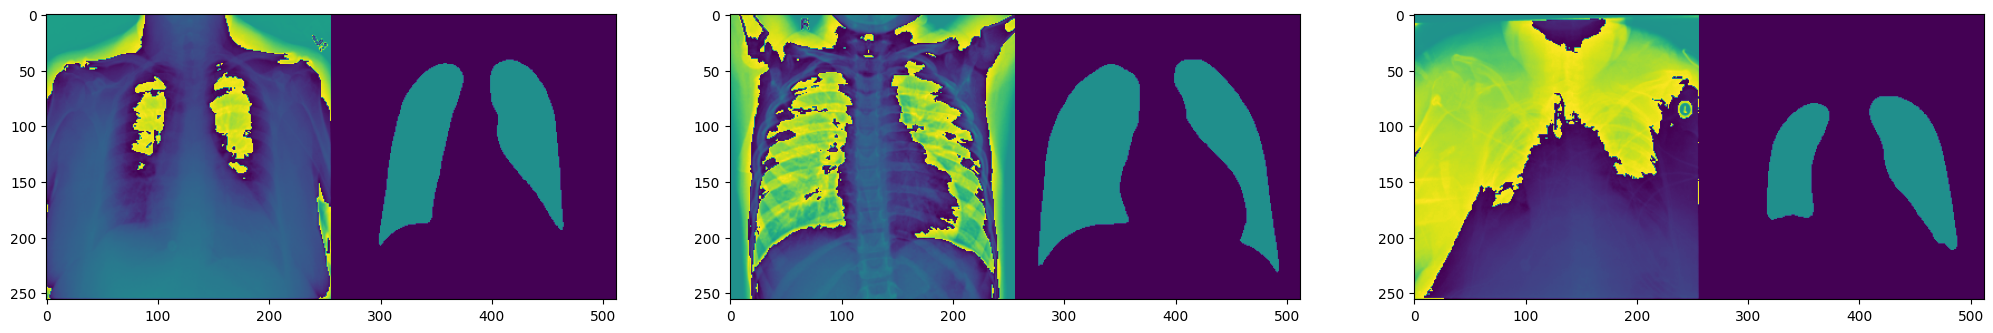

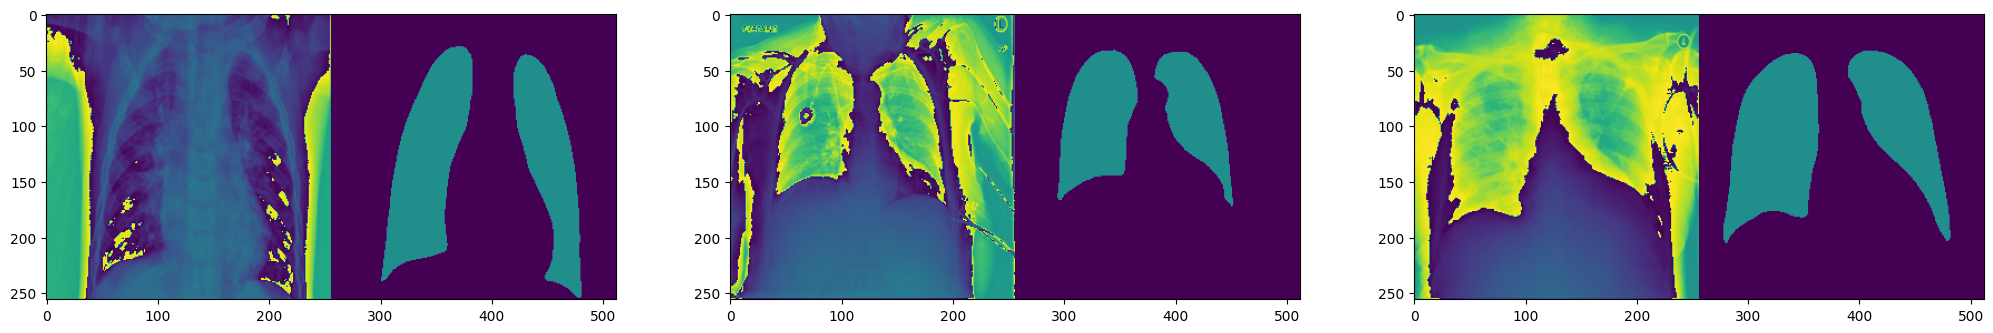

In [39]:
# Obtenir un batch d'images
dataiter = iter(train_dataset)
image, mask = next(dataiter)
plotMask(image, mask)

In [40]:
#del loss_history
import gc
gc.collect()
tf.keras.backend.clear_session()

loss_history = model.fit(train_dataset,
                         batch_size = batch_size,
                  epochs = 3,
                  validation_data = test_dataset,
                  callbacks=callbacks_list)

Epoch 1/3
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - BinaryIoU: 0.5148 - binary_accuracy: 0.6846 - loss: 0.3573
Epoch 1: val_loss improved from inf to 0.08526, saving model to cxr_reg_segmentation.best.keras
880/880 ━━━━━━━━━━━━━━━━━━━━ 1495s 2s/step - BinaryIoU: 0.5150 - binary_accuracy: 0.6848 - loss: 0.3571 - val_BinaryIoU: 0.8972 - val_binary_accuracy: 0.9609 - val_loss: 0.0853 - learning_rate: 1.0000e-04
Epoch 2/3
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - BinaryIoU: 0.9037 - binary_accuracy: 0.9632 - loss: 0.0795
Epoch 2: val_loss improved from 0.08526 to 0.05747, saving model to cxr_reg_segmentation.best.keras
880/880 ━━━━━━━━━━━━━━━━━━━━ 1455s 2s/step - BinaryIoU: 0.9037 - binary_accuracy: 0.9632 - loss: 0.0795 - val_BinaryIoU: 0.9292 - val_binary_accuracy: 0.9733 - val_loss: 0.0575 - learning_rate: 1.0000e-04
Epoch 3/3
880/880 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - BinaryIoU: 0.9306 - binary_accuracy: 0.9739 - loss: 0.0562
Epoch 3: val_loss improved from 0.05747 to 0.04636, saving mo

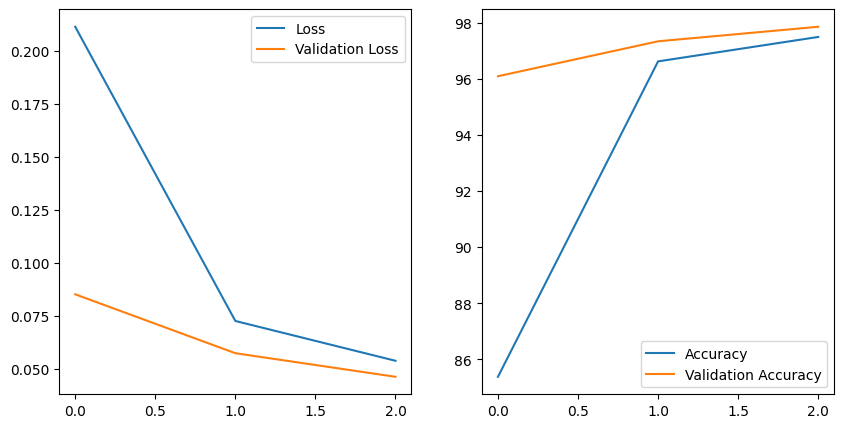

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

plt.show()

In [56]:
#model.load_weights("cxr_reg_weights.best.hdf5")


def test_accuracy(model, X, y):
    X_test, y_test = X, y
    batch_size = 8
    predictions = model.predict(X_test, batch_size=batch_size)

    binary_iou_metric = tf.metrics.BinaryIoU()
    binary_iou_metric.update_state(y_test,predictions)
    binaryIoU = binary_iou_metric.result().numpy()


    #dice_loss_score = tf.losses.Dice(y_test,predictions)
    #dice_loss_score.update_state(y_test,predictions)
    #dice_loss_score=dice_loss_score.result().numpy

    accuracy_metrics = tf.metrics.binary_accuracy
    accuracy_metrics.update_state(y_test,predictions)
    accuracy = accuracy_metrics.result().numpy()
    print(f"Sample size: {y_test.shape}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f'IoU: {binaryIoU:.4f}')
    #print(f'Dice Loss: {dice_loss_score:.4f}')
    X_test,y_test = 0,0

print("jeu de données d'entrainement")
test_accuracy(model, train_vol[:50], train_seg[:50])

print("jeu de données de paramétrage")
test_accuracy(model, test_vol, test_seg)

print("jeu de données de validation")
test_accuracy(model, valid_vol, valid_seg)

jeu de données d'entrainement
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step


AttributeError: 'function' object has no attribute 'update_state'

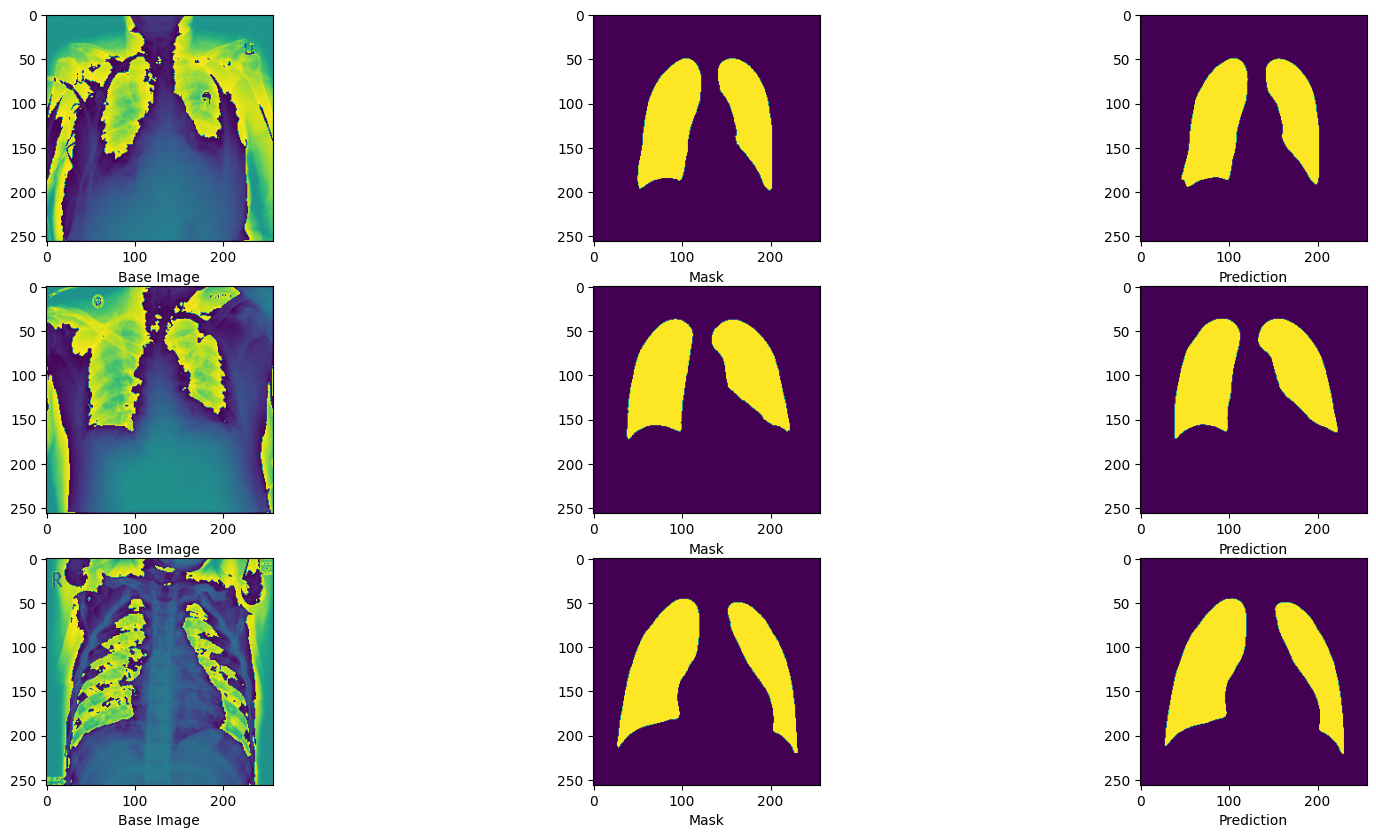

In [14]:
# Obtenir un batch d'images
dataiter = iter(val_dataset)
image, mask = next(dataiter)

preds = model.predict(image)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i])
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(mask[i])
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(preds[i])
    plt.xlabel("Prediction")
